# Speed comparison of Japanese tokenizers

I referred to below page.

[Python で分かち書き の速度比較 / janome, sudachi, ginza, mecab, fugashi, tinysegmenter - Qiita](https://qiita.com/kfjt/items/8b2f4a04e4befff18e19)

In [1]:
import time
import math
from typing import Dict, List, Callable

from janome.tokenizer import Tokenizer as JanomeTokenizer
from MeCab import Tagger as MeCabTagger
from sudachipy import dictionary as sudachi_dic

import requests

import pandas as pd
import seaborn as sns

In [2]:
NEKO_SENTENCES = (
    requests
    .get(
        "http://www.cl.ecei.tohoku.ac.jp/nlp100/data/neko.txt"
    )
    .content
    .decode()
    .split()
)
NEKO_SENTENCES_NUM = len(NEKO_SENTENCES)

In [3]:
mecab_tokenizer = MeCabTagger("-Owakati")
janome_tokenizer = JanomeTokenizer()
sudachi_tokenizer = sudachi_dic.Dictionary().create()

In [4]:
def mecab(text: str) -> List[str]:
    ret: List[str] = mecab_tokenizer.parse(text).split()
    return ret


def janome(text: str) -> List[str]:
    return [
        token for token in janome_tokenizer.tokenize(text, wakati=True)
    ]


def sudachi(text: str) -> List[str]:
    return [
        token.surface() for token in sudachi_tokenizer.tokenize(text)
    ]

In [7]:
def elapsed_times(func: Callable, trial_times: int = 100) -> Dict[str, List[int]]:
    ret = dict(text_length=[], elapsed_time=[])
    for i in range(10):
        sentence_num = math.ceil(NEKO_SENTENCES_NUM * float(i + 1)/10)
        text = "".join(NEKO_SENTENCES[0:sentence_num])
        text_length = len(text)
        total_elapsed_time = 0
        for _ in range(trial_times):
            start = time.perf_counter_ns()
            func(text)
            end = time.perf_counter_ns()
            elapsed_time = end - start
            total_elapsed_time += elapsed_time
            ret["text_length"].append(text_length)
            ret["elapsed_time"].append(elapsed_time)
        print(f"{func}[{i}]: {total_elapsed_time/1000/1000:.1f}ms")
    return ret

In [8]:
results = {
    tokenizer_name: elapsed_times(globals()[tokenizer_name], trial_times=10)
    for tokenizer_name in ("mecab", "janome", "sudachi")
}

<function mecab at 0x7f56a2a273a0>[0]: 357.4ms
<function mecab at 0x7f56a2a273a0>[1]: 721.0ms
<function mecab at 0x7f56a2a273a0>[2]: 1118.2ms
<function mecab at 0x7f56a2a273a0>[3]: 1483.1ms
<function mecab at 0x7f56a2a273a0>[4]: 1784.9ms
<function mecab at 0x7f56a2a273a0>[5]: 2037.7ms
<function mecab at 0x7f56a2a273a0>[6]: 2359.8ms
<function mecab at 0x7f56a2a273a0>[7]: 2576.7ms
<function mecab at 0x7f56a2a273a0>[8]: 2826.8ms
<function mecab at 0x7f56a2a273a0>[9]: 2947.7ms
<function janome at 0x7f56a2a275e0>[0]: 41173.7ms
<function janome at 0x7f56a2a275e0>[1]: 74909.9ms
<function janome at 0x7f56a2a275e0>[2]: 103682.3ms
<function janome at 0x7f56a2a275e0>[3]: 121060.7ms
<function janome at 0x7f56a2a275e0>[4]: 149541.5ms
<function janome at 0x7f56a2a275e0>[5]: 172365.8ms
<function janome at 0x7f56a2a275e0>[6]: 204309.7ms
<function janome at 0x7f56a2a275e0>[7]: 233385.6ms
<function janome at 0x7f56a2a275e0>[8]: 239928.1ms
<function janome at 0x7f56a2a275e0>[9]: 262980.7ms
<function suda

In [10]:
buff = []
for k, v in results.items():
    df = pd.DataFrame.from_dict(v)
    df["tokenizer name"] = k
    buff.append(df)

In [16]:
data = pd.concat(buff, ignore_index=True)
data = data.rename(
    columns={
        "elapsed_time": "elapsed time",
        "text_length": "text length"
    }
)
data["elapsed time [ms]"] = data["elapsed time"] / 1000 / 1000

<AxesSubplot:xlabel='text length', ylabel='elapsed time [ms]'>

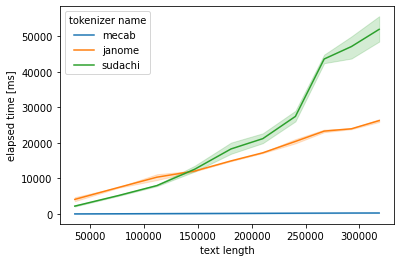

In [17]:
sns.lineplot(
    data=data,
    y="elapsed time [ms]",
    x="text length",
    hue="tokenizer name",
)